In [2]:
import numpy as np
import pandas as pd
import os
import torch
from tqdm.notebook import tqdm
import seaborn as sns
import sys
from torch import nn
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
from joblib import Parallel, delayed
from rdkit import Chem
import matplotlib.patheffects as pe
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
import pickle

In [7]:
with open('../EnamineNewTrain.pkl', 'rb') as f:
    df_train = pickle.load(f)
with open('../EnamineNewTest.pkl', 'rb') as f:
    df_val = pickle.load(f)

## Obtain data

- Obtain data, convert it to mol2vec embeddings
- Split into train and test set and cherry pick for negative binding affinities

In [8]:
mol_model = word2vec.Word2Vec.load('../mol2vec/examples/models/model_300dim.pkl')
protein = 'COc1cc2c(ncnc2cc1OC)Nc1cccc(c1)O'
pimg = Chem.MolFromSmiles(protein)
psent = MolSentence(mol2alt_sentence(pimg, 1))
pvec = sentences2vec([psent], mol_model, unseen='UNK')
mols_train = [Chem.MolFromSmiles(smile) for smile in df_train['smiles']]
mols_test = [Chem.MolFromSmiles(smile) for smile in df_val['smiles']]
sentence_train = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols_train]
sentence_test = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols_test]
embeddings_train = sentences2vec(sentence_train, mol_model, unseen='UNK')
embeddings_test = sentences2vec(sentence_test, mol_model, unseen='UNK')
X_train, y_train = embeddings_train, df_train['ba']
X_test, y_test = embeddings_test, df_val['ba']
X_test = [list(X_test[i]) for i in range(0, len(X_test)) if y_test[i] < 0]
y_test = [y_test[i] for i in range(0, len(y_test)) if y_test[i] < 0]
X_train = [list(X_train[i]) for i in range(0, len(X_train)) if y_train[i] < 0]
y_train = [y_train[i] for i in range(0, len(y_train)) if y_train[i] < 0]

[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not removing hydrogen atom without neighbors
[21:02:38] WARNING: not r

# Train GPR

- Pick 5000 random points and train the GPR

In [9]:
idx = np.random.choice(len(X_train), 5000, replace=False)
X_cur = []
y_cur = []
for i in idx:
    X_cur.append(X_train[i])
    y_cur.append(y_train[i])

In [39]:
df = {}
df['mol2vec'] = X_cur
df['ba'] = y_cur
with open('./molecules/labelled.pkl', 'wb') as f:
    pickle.dump(df, f)

In [40]:
df = {}
df['mol2vec'] = X_test
df['ba'] = y_test
with open('./molecules/test.pkl', 'wb') as f:
    pickle.dump(df, f)

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
print("Length of training samples: ", len(X_cur))
kernel = RBF(5.0) + WhiteKernel(1.0) 
gpr =  GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.01).fit(X_cur, y_cur)
print("R2 Score on the test set: ", gpr.score(X_test, y_test))

Length of training samples:  5000
R2 Score on the test set:  0.8751941974701758


In [25]:
y_pred = gpr.predict(X_test, return_std=True)
print('MAE: ', mean_absolute_error(y_pred[0], y_test))
print('MSE: ', mean_squared_error(y_pred[0], y_test))
print('R2: ', r2_score(y_pred[0], y_test))

MAE:  0.4174642176822602
MSE:  0.3160348930763164
R2:  0.8549372002702459


Text(-13.3, -2.6, '$R^2$: 0.854 ')

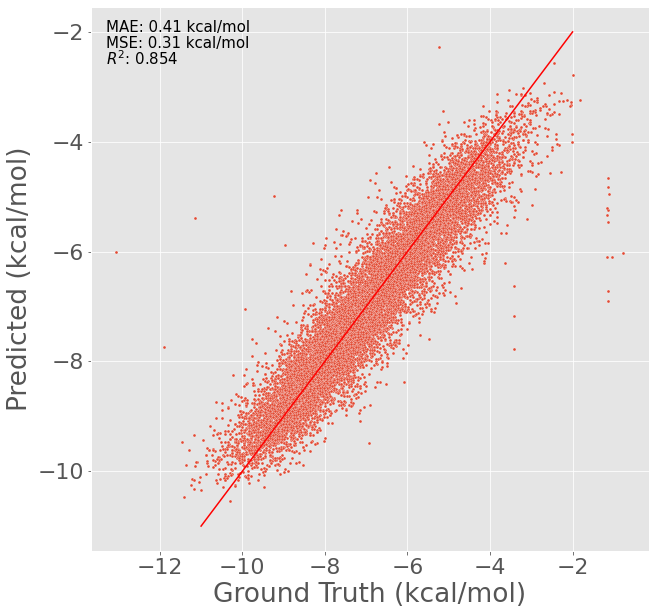

In [15]:
df = {"x": y_test, "y": y_pred[0]}
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
a = np.arange(-11, -1, 1)
b = np.arange(-11, -1, 1)
plt.plot(a, b, color='red')
sns.scatterplot(data=df, x="x", y="y", s=9)
plt.xlabel("Ground Truth (kcal/mol)")
plt.ylabel("Predicted (kcal/mol)")
plt.text(-13.3, -2, 'MAE: 0.41 kcal/mol ', fontsize = 15)
plt.text(-13.3, -2.3, 'MSE: 0.31 kcal/mol', fontsize = 15)
plt.text(-13.3, -2.6, '$R^2$: 0.854 ', fontsize = 15)

## Render newly generated molecules

- These molecules have been generated from `Analysis.ipynb`.
- 500 molecules are generated
- We now test this on the pre-trained GPR above

In [17]:
def smile_to_vec(smiles):
    a = [Chem.MolFromSmiles(smile) for smile in smiles]
    b = [MolSentence(mol2alt_sentence(mol, 1)) for mol in a]
    c = sentences2vec(b, mol_model, unseen='UNK')
    return c

In [23]:
X_test_gen = []
y_test_gen = []
df_train_gen = pd.read_pickle("./gpr_gen.pkl")
smiles_train_set = df_train_gen['Smile'].values
y_train_set = df_train_gen['Binding Affinity'].values
smiles_train = [smiles_train_set[i] for i in range(len(smiles_train_set)) if y_train_set[i] < -2]
y_train_gen = [y_train_set[i] for i in range(len(y_train_set)) if y_train_set[i] < -2]
X_train_gen = smile_to_vec(smiles_train)
X_test_new = X_test.copy()
y_test_new = y_test.copy()
X_test_new.extend(X_train_gen)
y_test_new.extend(y_train_gen)

In [24]:
y_pred_new = gpr.predict(X_test_new, return_std=True)
print('MAE: ', mean_absolute_error(y_pred_new[0], y_test_new))
print('MSE: ', mean_squared_error(y_pred_new[0], y_test_new))
print('R2: ', r2_score(y_pred_new[0], y_test_new))

MAE:  0.5675271802022537
MSE:  1.2415391922851866
R2:  0.4805935244832812


In [26]:
y_pred_gen = gpr.predict(X_train_gen, return_std=True)

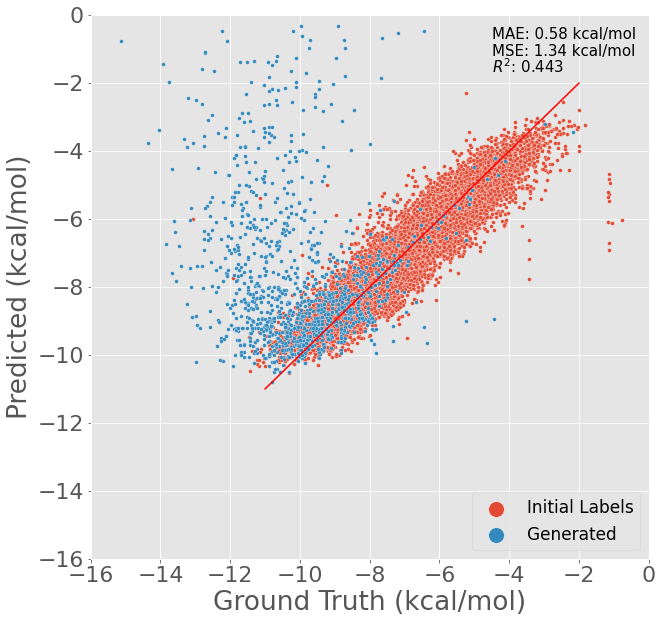

In [27]:
df1 = {"x": y_test, "y": y_pred[0]}
df2 = {"x": y_train_gen, "y": y_pred_gen[0]}
plt.figure(figsize=(10,10))
a = np.arange(-11, -1, 1)
b = np.arange(-11, -1, 1)
plt.plot(a, b, color='red')
sns.scatterplot(data=df1, x="x", y="y", s=15, label='Initial Labels')
sns.scatterplot(data=df2, x="x", y="y", s=15, label='Generated')
plt.text(-4.5, -0.7, 'MAE: 0.58 kcal/mol ', fontsize = 15)
plt.text(-4.5, -1.2, 'MSE: 1.34 kcal/mol', fontsize = 15)
plt.text(-4.5, -1.7, '$R^2$: 0.443 ', fontsize = 15)
plt.xlabel("Ground Truth (kcal/mol)")
plt.ylabel("Predicted (kcal/mol)")
plt.xlim(-16, 0)
plt.ylim(-16, 0)
#plt.title("Correlation between predicting and ground truth binding affinities before retraining", fontsize=22)
plt.legend(loc='lower right', prop={'size': 17}, markerscale=4)

## Perform on GPR trained inside AL pipeline

- `gpr_al_inducted.pkl` has already been inducted into the MoLeGULAR pipeline.
- We will now perform the above experiment for the inducted GPR

In [33]:
with open('./gpr_al_inducted.pkl', 'rb') as f:
    gpr = pickle.load(f)

In [34]:
y_pred_new = gpr.predict(X_test_new, return_std=True)
print('MAE: ', mean_absolute_error(y_pred_new[0], y_test_new))
print('MSE: ', mean_squared_error(y_pred_new[0], y_test_new))
print('R2: ', r2_score(y_pred_new[0], y_test_new))

MAE:  0.45225448071415975
MSE:  0.40953288752509837
R2:  0.8516776412788165


In [35]:
y_pred_gen = gpr.predict(X_train_gen, return_std=True)

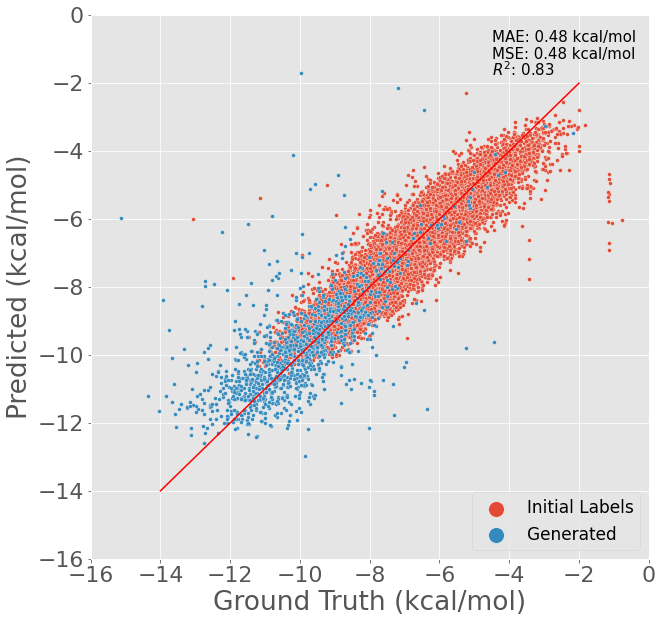

In [36]:
df1 = {"x": y_test, "y": y_pred[0]}
df2 = {"x": y_train_gen, "y": y_pred_gen[0]}
plt.figure(figsize=(10,10))
a = np.arange(-14, -1, 1)
b = np.arange(-14, -1, 1)
plt.plot(a, b, color='red')
sns.scatterplot(data=df1, x="x", y="y", s=15, label='Initial Labels')
sns.scatterplot(data=df2, x="x", y="y", s=15, label='Generated')
plt.text(-4.5, -0.8, 'MAE: 0.48 kcal/mol ', fontsize = 15)
plt.text(-4.5, -1.3, 'MSE: 0.48 kcal/mol', fontsize = 15)
plt.text(-4.5, -1.8, '$R^2$: 0.83 ', fontsize = 15)
plt.xlabel("Ground Truth (kcal/mol)")
plt.ylabel("Predicted (kcal/mol)")
plt.xlim(-16, 0)
plt.ylim(-16, 0)
#plt.title("Correlation between predicting and ground truth binding affinities after retraining", fontsize=22, y=1.02)
plt.legend(loc='lower right', prop={'size': 17}, markerscale=4)